## Bike Sharing Demand

https://www.kaggle.com/c/bike-sharing-demand

According to historical data on bicycle rental and weather conditions, it is necessary to forecast the demand for bicycle rental.

## Import libraries

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.model_selection import cross_validate,  GridSearchCV
from matplotlib import pyplot as plt
%matplotlib inline

## Load the data

In [103]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df = df_train.append(df_test, sort = False)
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


For each rental day, the following features are known (as they were indicated in the data source):
* _datetime_: time of rent
* _season_: 1 - spring, 2 - summer, 3 - autumn, 4 - winter
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: from 1 to 12
* _holiday_: 0 - no holiday, 1 - there is a holiday
* _weekday_: 0 to 6
* _workingday_: 0 - non-working day, 1 - working day
* _weathersit_: assessment of weather favorableness from 1 (clean, clear day) to 4 (rain, fog)
* _temp_: temperature in Celsius
* _atemp_: feels like temperature in Celsius
* _humidity_: humidity
* _windspeed_: wind speed in miles per hour
* _casual_: number of non-registered user rentals initiated
* _registered_: number of registered user rentals initiated
* _count_: total number of rented bikes (this is a target attribute, we will predict it)

So, we have real, binary and nominal (ordinal) signs, and with all of them it is possible to work as with real ones. It is also possible to work with nominal signs as with real ones, because they are assigned an order. 

## Create more features

In [104]:
df["hour"] = [t.hour for t in pd.DatetimeIndex(df.datetime)]
df["day"] = [t.dayofweek for t in pd.DatetimeIndex(df.datetime)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.datetime)]
df['year'] = [t.year for t in pd.DatetimeIndex(df.datetime)]
df['year'] = df['year'].map({2011:0, 2012:1})
df = df.drop(['datetime', 'registered', 'casual'], axis=1)

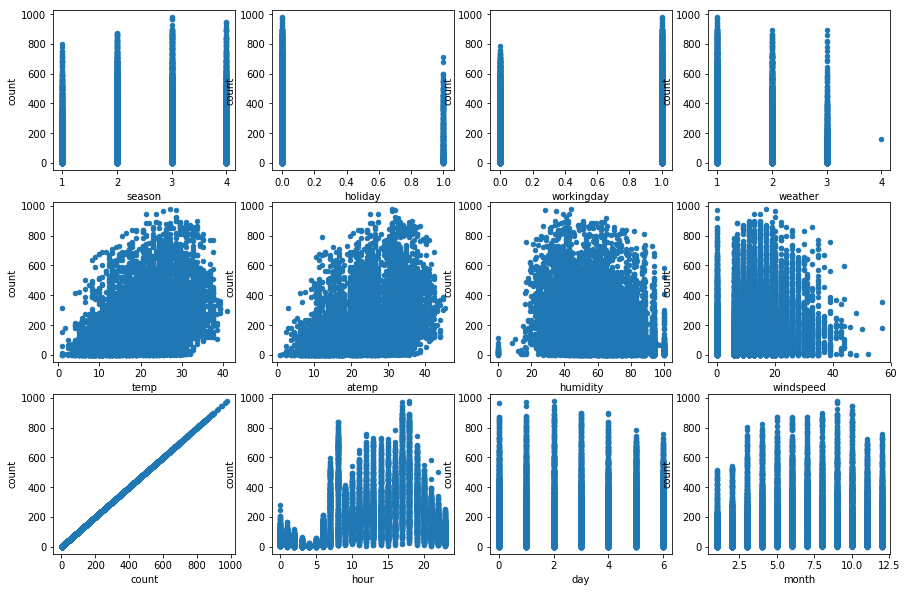

In [105]:
#Let's look at the graphs, as the target attribute depends on the rest
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "count", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

Temperature, humidity and windspeed are hard to visualize, a better way is to convert the variables into intervals or so called bins and then treat it like a discrete variable

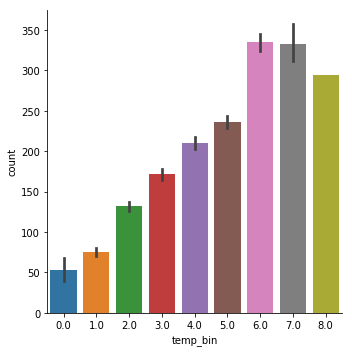

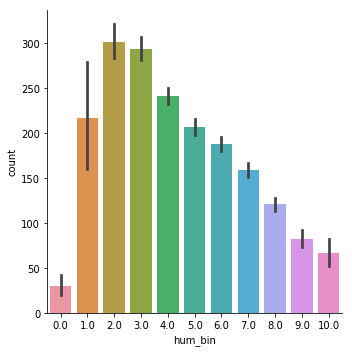

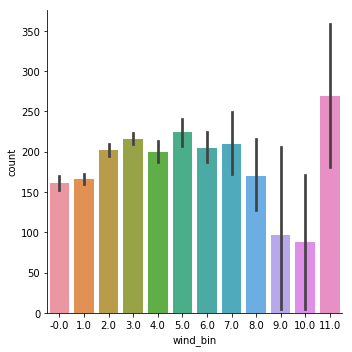

In [107]:
#Temperature
new_df=df.copy()
new_df['temp_bin']=np.floor(new_df['temp'])//5
new_df['temp_bin'].unique()
# now we can visualize as follows
sns.catplot(x="temp_bin",y="count",data=new_df,kind='bar')

#Humidity
new_df['hum_bin']=np.floor(new_df['humidity'])//10
new_df['hum_bin'].unique()
# now we can visualize as follows
sns.catplot(x="hum_bin",y="count",data=new_df,kind='bar')

#Windspeed
new_df['wind_bin']=np.floor(new_df['windspeed'])//5
new_df['wind_bin'].unique()
# now we can visualize as follows
sns.catplot(x="wind_bin",y="count",data=new_df,kind='bar')

## Data pre-processing

In [109]:
list(df)

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'count',
 'hour',
 'day',
 'month',
 'year']

In [114]:
categorical = ['season', 'weather', 'hour', 'day', 'month', 'year','holiday','workingday']
numerical = ['temp','atemp','humidity', 'windspeed']
for var in categorical:
    df[var] = df[var].astype("category")

## Splitting Train and Test data

In [133]:
X_train = df[pd.notnull(df['count'])]
X_test = df[~pd.notnull(df['count'])]
y = X_train["count"]
X = X_train.drop("count", axis = 1)

## Evaluate the score

In [134]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Linear Regression Model

In [138]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(y)
lModel.fit(X = X,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= X)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

('RMSLE Value For Linear Regression: ', 0.9778188829547181)


## Ridge

{'alpha': 0.1, 'max_iter': 3000}
('RMSLE Value For Ridge Regression: ', 0.9778188678218612)


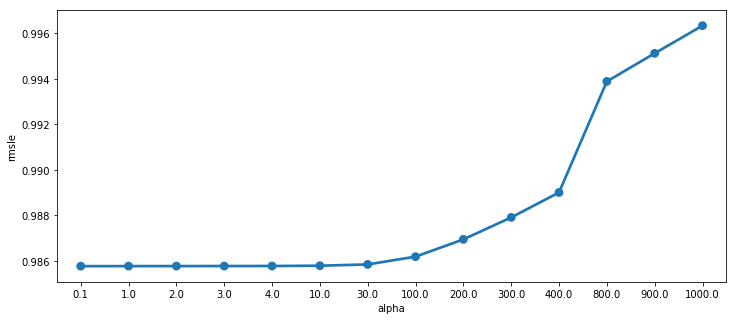

In [144]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(y)
grid_ridge_m.fit(X, yLabelsLog )
preds = grid_ridge_m.predict(X)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Lasso

{'alpha': 0.005, 'max_iter': 3000}
('RMSLE Value For Lasso Regression: ', 0.9779547810163672)


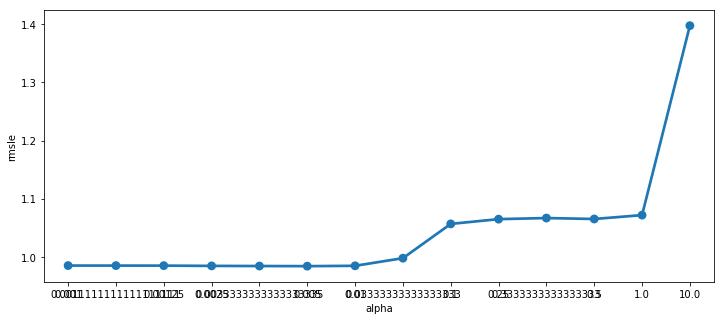

In [148]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(y)
grid_lasso_m.fit(X, yLabelsLog )
preds = grid_lasso_m.predict(X)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## Random Forest Regressor

In [121]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [122]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [123]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 46.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [124]:
print rf_random.best_score_
print rf_random.best_params_

0.7077308574519467
{'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1600, 'max_features': 'auto', 'min_samples_split': 5, 'max_depth': 90}


## GridSearchCV with cross-validation

In [125]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [126]:
# Fit the grid search to the data
grid_search.fit(X_train, y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 22.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'min_samples_leaf': [3, 4, 5], 'n_estimators': [100, 200, 300, 1000], 'min_samples_split': [8, 10, 12], 'max_features': [2, 3], 'max_depth': [80, 90, 100, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [127]:
print grid_search.best_score_
print grid_search.best_params_

0.6650574543706798
{'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 100, 'min_samples_split': 8, 'max_features': 3, 'max_depth': 90}


Text(0.5,1,'random forest model')

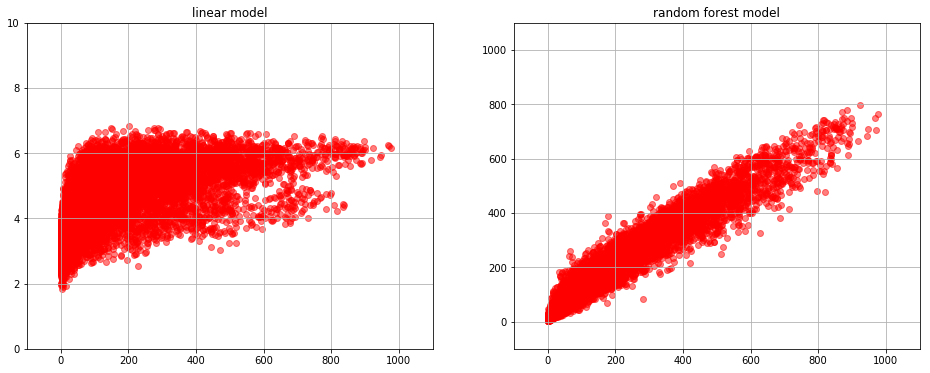

In [156]:
import pylab
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(0,10)
pylab.scatter(y, lModel.predict(X), alpha=0.5, color = 'red')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(y, grid_search.best_estimator_.predict(X), alpha=0.5, color = 'red')
pylab.title('random forest model')